In [1]:
import pandas as pd

import json
from pandas.io.json import json_normalize

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import plot_importance
import numpy as np

from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost

from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV


sns.set(rc={'figure.figsize':(15, 7)})

import warnings
warnings.filterwarnings('ignore')

In [2]:
openfile=open("ultimate_data_challenge.json")
jsondata=json.load(openfile)

df = pd.DataFrame(jsondata)

#Cast the dates to the right format
df["last_trip_dt"] = pd.to_datetime(df["last_trip_date"])
df["signup_dt"] = pd.to_datetime(df["signup_date"])

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,last_trip_dt,signup_dt
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,2014-06-17,2014-01-25
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2014-05-05,2014-01-29
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,2014-01-07,2014-01-06
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2014-06-29,2014-01-10
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,2014-03-15,2014-01-27


#### Create retention label
To adebtify active customers, the most recent trip will be used as the reference point and customers that took a trip in the preceeding 30days will be considered as active.

In [3]:
#Most recent trip
maxdate = max(df["last_trip_dt"]) - timedelta(days=30)

#Create new variable for Foreclosure for mortgages 
df["activen"] = df.apply(lambda row: 1 if row["last_trip_dt"] > maxdate else 0, axis=1)

df["activec"] = df['activen'].apply(lambda row: 'Active' if row == 1 else 'Not Active')

#No of days active
df["daysactive"] = df["last_trip_dt"] - df["signup_dt"]

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,last_trip_dt,signup_dt,activen,activec,daysactive
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,2014-06-17,2014-01-25,1,Active,143 days
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2014-05-05,2014-01-29,0,Not Active,96 days
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,2014-01-07,2014-01-06,0,Not Active,1 days
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2014-06-29,2014-01-10,1,Active,170 days
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,2014-03-15,2014-01-27,0,Not Active,47 days


#### Percentage of Active - None Active Customers

In [4]:
df_active = df['activen'].groupby(df['activec']).agg('count')
df_active = pd.DataFrame(df_active)

df_active.columns = ['Status']

dd = df_active.reset_index(level=0)
dd.columns = ['Status','NoofCustomers']

dd

,Status,NoofCustomers
0,Active,18310
1,Not Active,31690


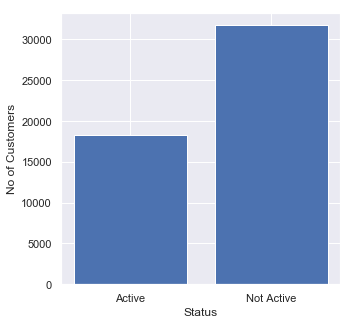

In [5]:
plt.figure(1, figsize=(5, 5))
plt.bar(dd['Status'], dd['NoofCustomers'], data=dd)
plt.xlabel('Status')
plt.ylabel('No of Customers')
plt.show()

The plots above show that 63.38% of the customers were not active as of the 01 July 2014.

In [6]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,last_trip_dt,signup_dt,activen,activec,daysactive
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,2014-06-17,2014-01-25,1,Active,143 days
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2014-05-05,2014-01-29,0,Not Active,96 days
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,2014-01-07,2014-01-06,0,Not Active,1 days
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2014-06-29,2014-01-10,1,Active,170 days
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,2014-03-15,2014-01-27,0,Not Active,47 days


In [7]:
dfb = df.loc[:,['ultimate_black_user', 'activec']]
dfb['COUNTER'] =1 
df_b = dfb.groupby(['ultimate_black_user', 'activec'])['COUNTER'].sum()


df_black = pd.DataFrame(df_b)

df_black.columns = ['customers']

#df_black
df_black1 = df_black.reset_index(drop=False)
#db.columns = ['Status','NoofCustomers']
df_black1

,ultimate_black_user,activec,customers
0,False,Active,8951
1,False,Not Active,22195
2,True,Active,9359
3,True,Not Active,9495


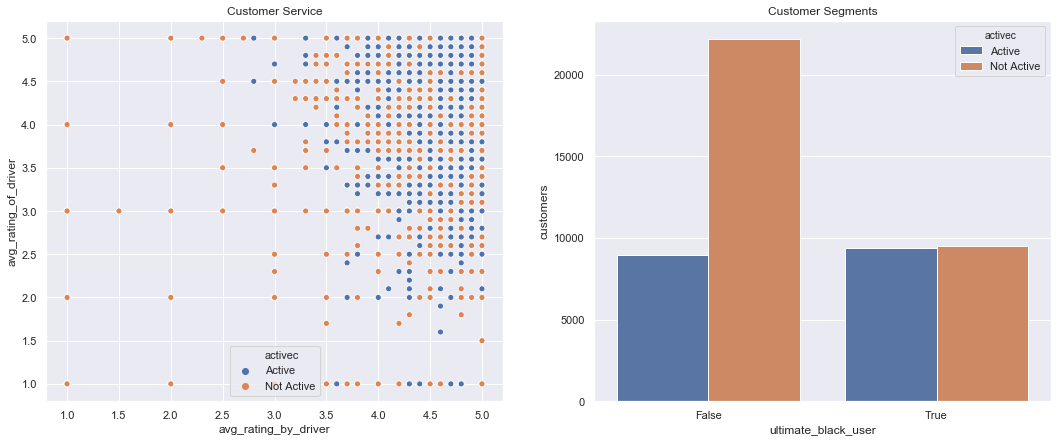

In [8]:
plt.rcParams["figure.figsize"] = (18,7)
fig, axs = plt.subplots(ncols=2)
sns.set(font_scale=1)

#Black/Non Back User (customer Segmentation)
sns.scatterplot(x=df.loc[:,'avg_rating_by_driver'], y=df.loc[:,'avg_rating_of_driver'], hue=df['activec'], ax = axs[0]).set_title('Customer Service')

sns.barplot(x=df_black1.ultimate_black_user, y=df_black1.customers, hue=df_black1.activec, ax = axs[1]).set_title('Customer Segments')

plt.show()

The first plot above explores the customer service by looking at the average rating of drivers a customer had over the period and the average rating of the customers by the drivers. While most of the data is skewed toward high rating by customer and drivers, it seems that most of the cutomers that gave lower rating and rater low by the drivers were not retain. Which could perhaps be associated with incidences.

On the other hand, It seems 50% of Ultimate Black users were retained. Whereas, more 70% of non-black users were not retain. Again, this could be as a result of the level of customer service receive at the lower customer segment.

#### Preprocessing 
To handle the missing data, we will drop cases of missing data and then check percentage of data lost and the didtribution of the resulting dataset

In [10]:
df.dropna(inplace=True)
len(df)

41445

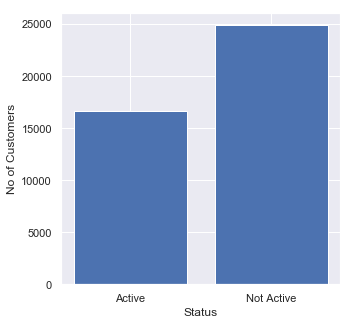

In [11]:
df_active = df['activen'].groupby(df['activec']).agg('count')
df_active = pd.DataFrame(df_active)

df_active.columns = ['Status']

dd = df_active.reset_index(level=0)
dd.columns = ['Status','NoofCustomers']

dd

plt.figure(1, figsize=(5, 5))
plt.bar(dd['Status'], dd['NoofCustomers'], data=dd)
plt.xlabel('Status')
plt.ylabel('No of Customers')
plt.show()

After droping the missing data, the retained customers are still well represented and the number of users that are not active are still much more than active users. Hence, thiss strategy will be adopted.

In [12]:
df_label = df.loc[:, ["activen",'activec']]

df_features = df.drop(columns =['signup_date', 'last_trip_date', 'last_trip_dt','signup_dt',"activen",'activec','daysactive'])

lbe = LabelEncoder()

df_features['city'] = lbe.fit_transform(df['city'])
df_features['phone'] = lbe.fit_transform(df['phone'])
df_features['ultimate_black_user'] = lbe.fit_transform(df['ultimate_black_user'])

df_feature_d = pd.get_dummies(df_features, columns=['city', 'phone','ultimate_black_user'], drop_first=True)

#df_feature_d['daysactive'] = pd.to_numeric( df_feature_d['daysactive'] / np.timedelta64(1, 'D'))


Initial model had about 78% accuracy even after cross validation. Hence, the number of days before becoming inactive was calculated and added as  valriable to increase predictive power.

### Split Data into Training and Test Set and confirm proportions

In [13]:
scaler = StandardScaler()
transform = scaler.fit_transform(df_feature_d)

transform.shape

# Split the data into a training and test set.
X = df_feature_d
y = df_label['activen']
xtrain, xtest, ytrain, ytest = train_test_split(X, y,random_state=5)

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(transform, df_label['activen'].values,random_state=5)

i = list(ytrain)
j = list(ytest)
print('There are {0} None Active and {1} Active in the training set'.format(i.count(0), i.count(1)))
print('There are {0} None Active and {1} Active in the training set'.format(j.count(0), j.count(1)))

There are 18655 None Active and 12428 Active in the training set
There are 6182 None Active and 4180 Active in the training set


#### Baseline Model

In [14]:
clf = XGBClassifier(max_features=None)
# Fit the model on the trainng data.
clf.fit(xtrain1, ytrain1)
# Print the accuracy from the testing data.
print(accuracy_score(ytest1, clf.predict(xtest1)))

0.7833429839799266


#### Cross Validation with Baseline Model

In [15]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 10
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [16]:
clf = XGBClassifier(max_features=None, )
score = cv_score(clf, xtrain1, ytrain1)
print(score)

0.7831297996061586


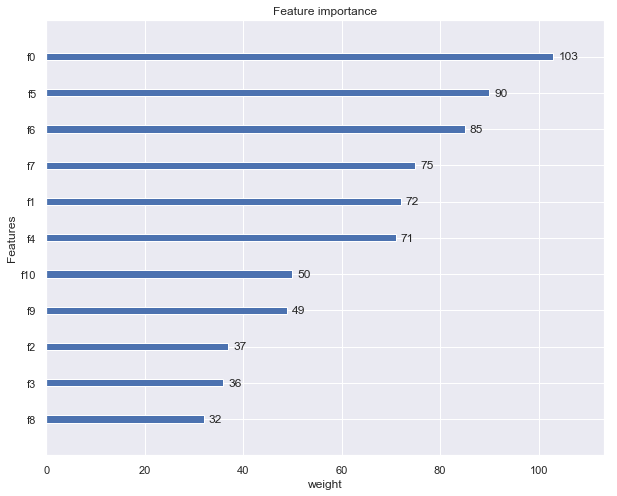

In [17]:
ax = plot_importance(clf, importance_type='weight', xlabel='weight', max_num_features=20)
ax.figure.set_size_inches(10,8)
pyplot.show()

In [18]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.get_booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v for k,v in imp_dict.items()}

dd = get_xgb_imp(clf, df_feature_d.columns)

In [19]:
dd1 = pd.DataFrame(
    {'features': list(dd.keys()),
     'coef': list(dd.values())
    })


In [20]:
feat = np.array(list(dd.values()))
lbl = np.array(list(dd.keys()))

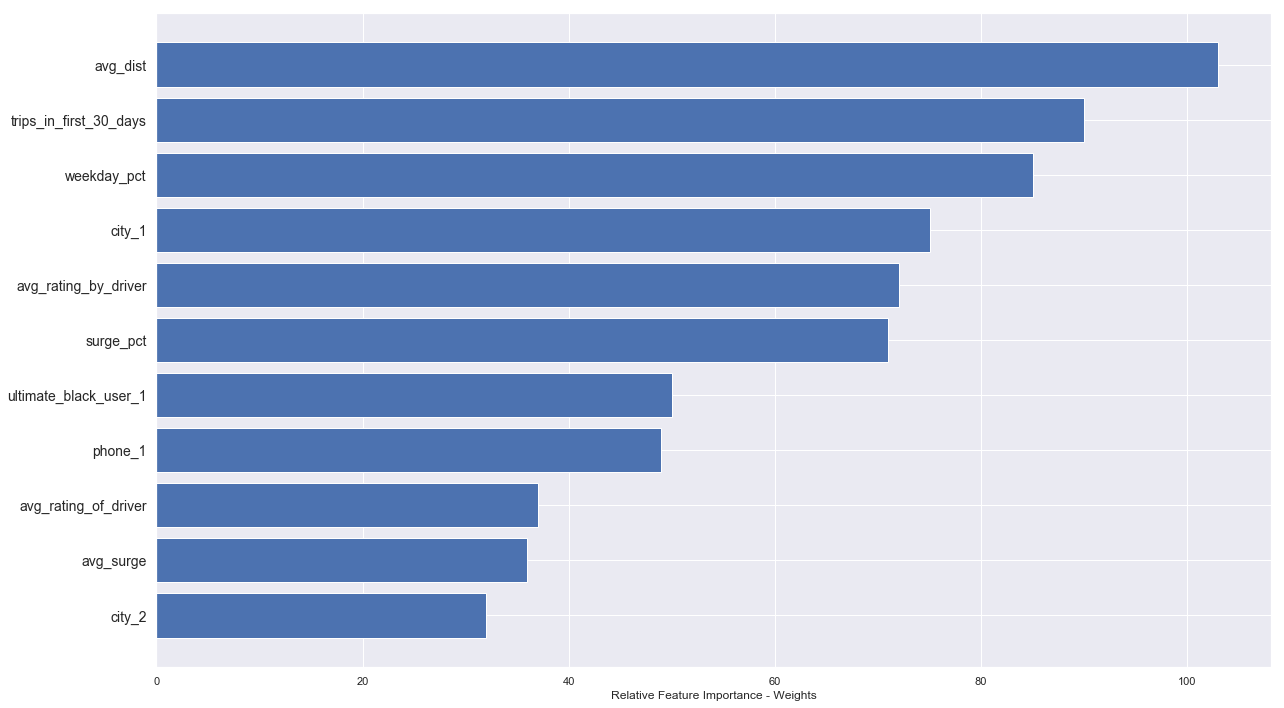

In [21]:
plt.rcParams["figure.figsize"] = (18,10)

feature_importance = feat
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos[-16:][::-1], feature_importance[sorted_idx][-16:][::-1], align='center')
featax.set_yticks(pos[-16:][::-1])
featax.set_yticklabels(np.array(lbl)[sorted_idx][-16:][::-1], fontsize=14)
featax.set_xlabel('Relative Feature Importance - Weights')

plt.tight_layout()   
plt.show()

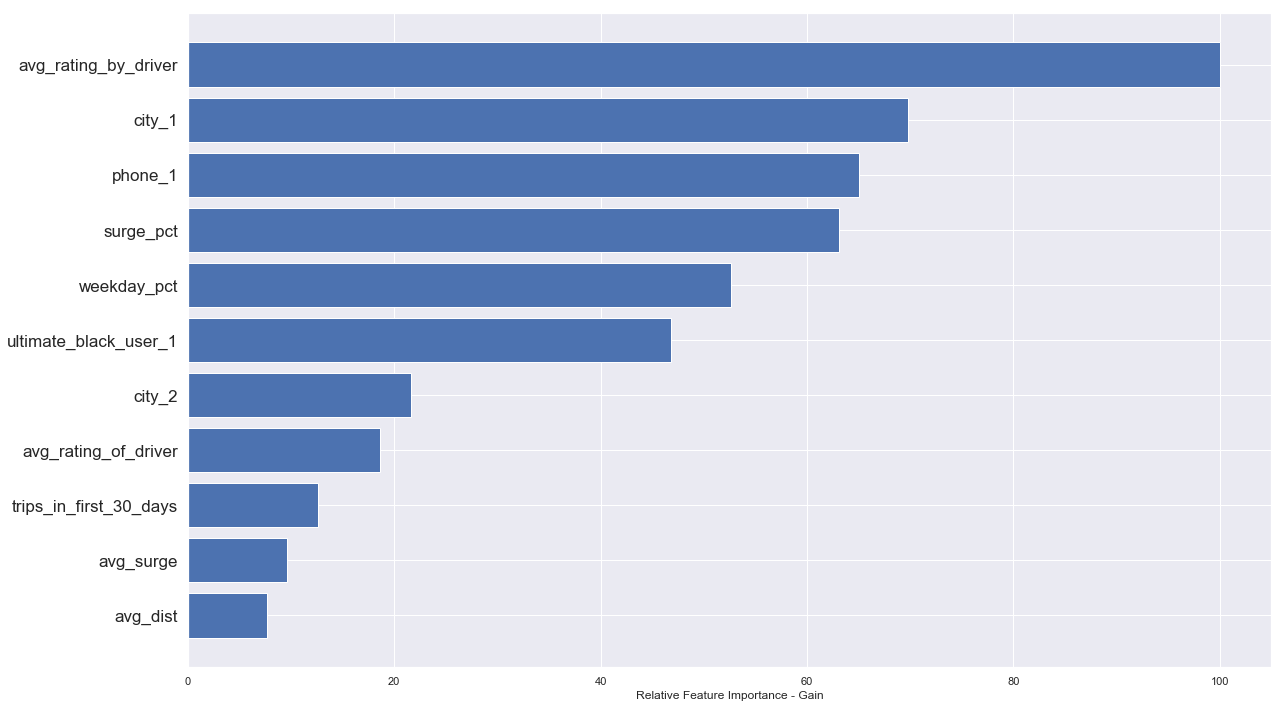

In [22]:
plt.rcParams["figure.figsize"] = (18,10)

feature_importance = abs(clf.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos[-16:][::-1], feature_importance[sorted_idx][-16:][::-1], align='center')
featax.set_yticks(pos[-16:][::-1])
featax.set_yticklabels(np.array(df_feature_d.columns)[sorted_idx][-16:][::-1], fontsize=17)
featax.set_xlabel('Relative Feature Importance - Gain')

plt.tight_layout()   
plt.show()

#### Confusion Matrix of Training set

In [23]:
tn, fp, fn, tp = confusion_matrix(clf.predict(xtrain1), ytrain1).ravel()
(tn, fp, fn, tp)

(15760, 3729, 2895, 8699)

In [24]:
print(classification_report(ytrain1, clf.predict(xtrain1)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83     18655
           1       0.75      0.70      0.72     12428

   micro avg       0.79      0.79      0.79     31083
   macro avg       0.78      0.77      0.78     31083
weighted avg       0.79      0.79      0.79     31083



#### ROC Curve Training

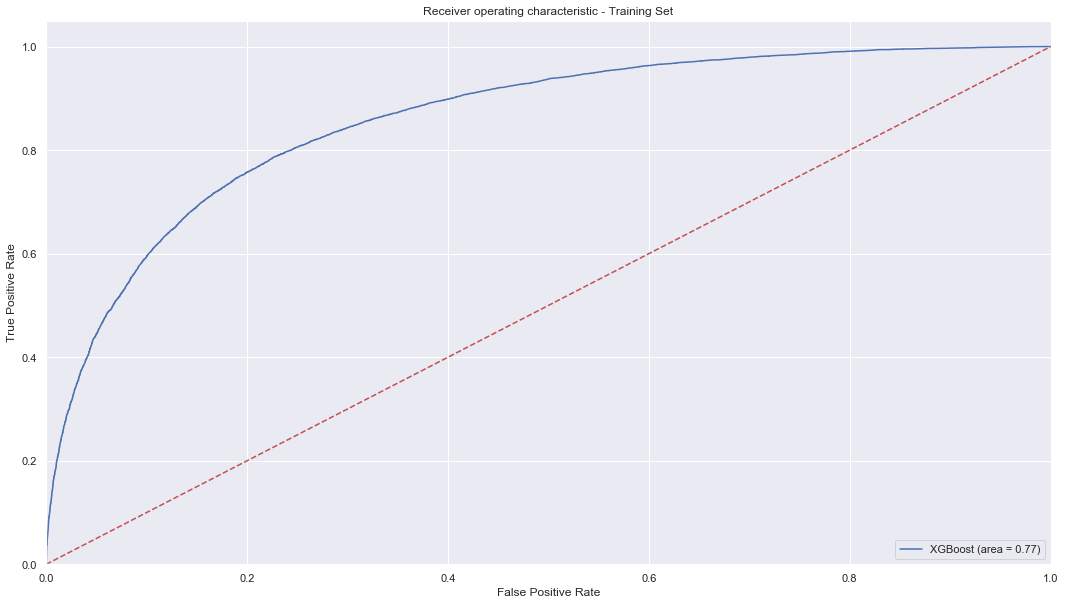

In [25]:
logit_roc_auc = roc_auc_score(ytrain1, clf.predict(xtrain1))
fpr, tpr, thresholds = roc_curve(ytrain1, clf.predict_proba(xtrain1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Training Set')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Confusion Matrix of Test set

In [26]:
tn, fp, fn, tp = confusion_matrix(clf.predict(xtest1), ytest1).ravel()
(tn, fp, fn, tp)

(5164, 1224, 1018, 2956)

In [27]:
print(classification_report(ytest1, clf.predict(xtest1)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      6182
           1       0.74      0.71      0.73      4180

   micro avg       0.78      0.78      0.78     10362
   macro avg       0.78      0.77      0.77     10362
weighted avg       0.78      0.78      0.78     10362



#### ROC Curve Test set

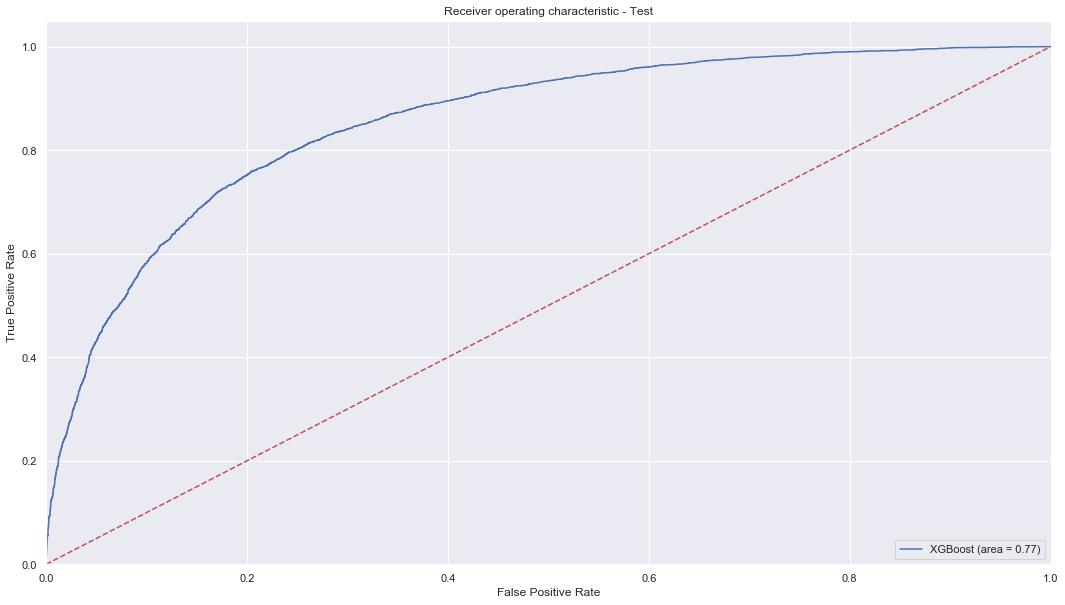

In [28]:
logit_roc_auc = roc_auc_score(ytest1, clf.predict(xtest1))
fpr, tpr, thresholds = roc_curve(ytest1, clf.predict_proba(xtest1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Test')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Importance of Features - Validation

In [29]:
coef = (np.std(xtrain1, 0)*clf.feature_importances_)
coef_std = (np.std(df_feature_d.values, 0)*clf.feature_importances_)

In [30]:
feature_imp = pd.DataFrame(
    {'features': df_feature_d.columns,
     'coef': coef[0],
     'coef_abs': abs(coef[0])
    })

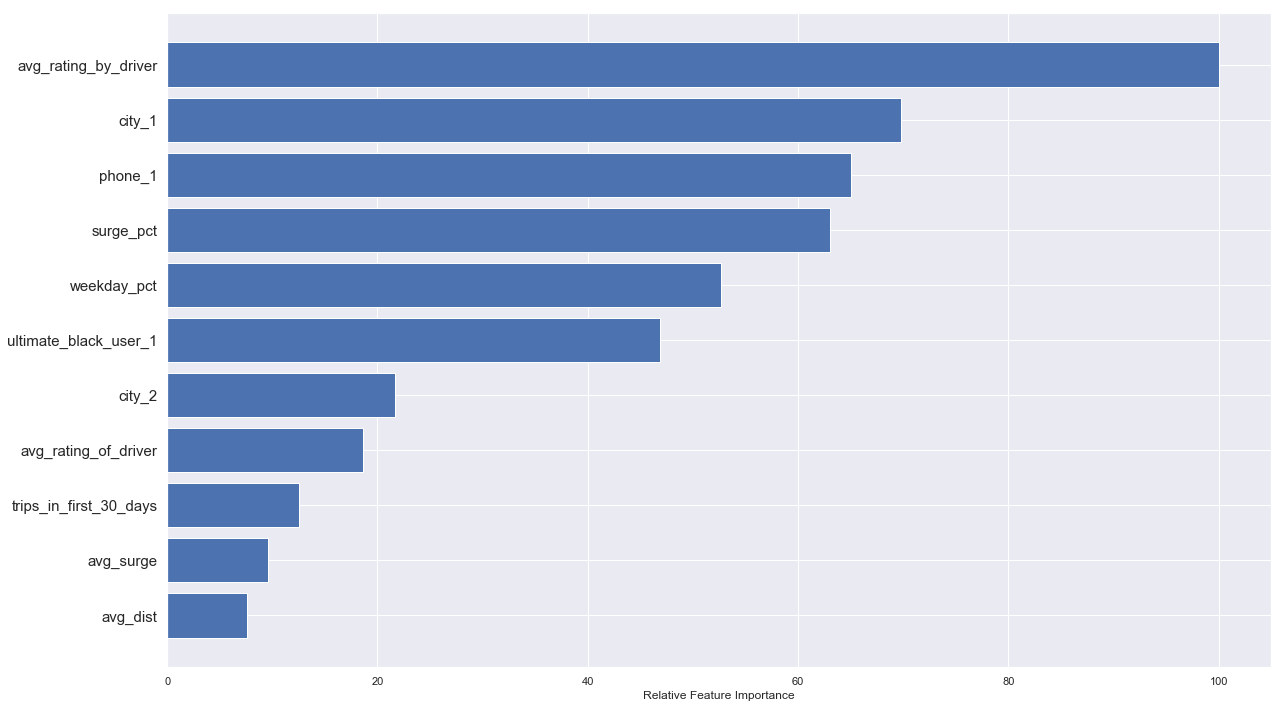

In [31]:
plt.rcParams["figure.figsize"] = (18,10)

#feature_importance = abs(clf.best_estimator_.coef_[0])
feature_importance = abs(clf.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(df_feature_d.columns)[sorted_idx], fontsize=15)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()
